In [13]:
import matplotlib.pyplot as plt
from environment import SecCom_Env
from system_configuration import Config
import numpy as np
import pandas as pd

***Kiểm tra logic di chuyển của môi trường***

In [14]:
config = Config()
config.init_unstatic_value()
env = SecCom_Env(config)

obs, info = env.reset()

user_positions = {i: {'x': [], 'y': []} for i in range(config.M_users)}

# Eve position
eve = env.basestation.eva
eve_pos = (eve.x, eve.y)

# BS position
bs_pos = (0, 0)

done = False
cnt = 0
while cnt < 1000:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    
    for i, user in enumerate(env.basestation.usrList):
        user_positions[i]['x'].append(user.x)
        user_positions[i]['y'].append(user.y)
    
    cnt += 1
    done = terminated or truncated

check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check position
check posi

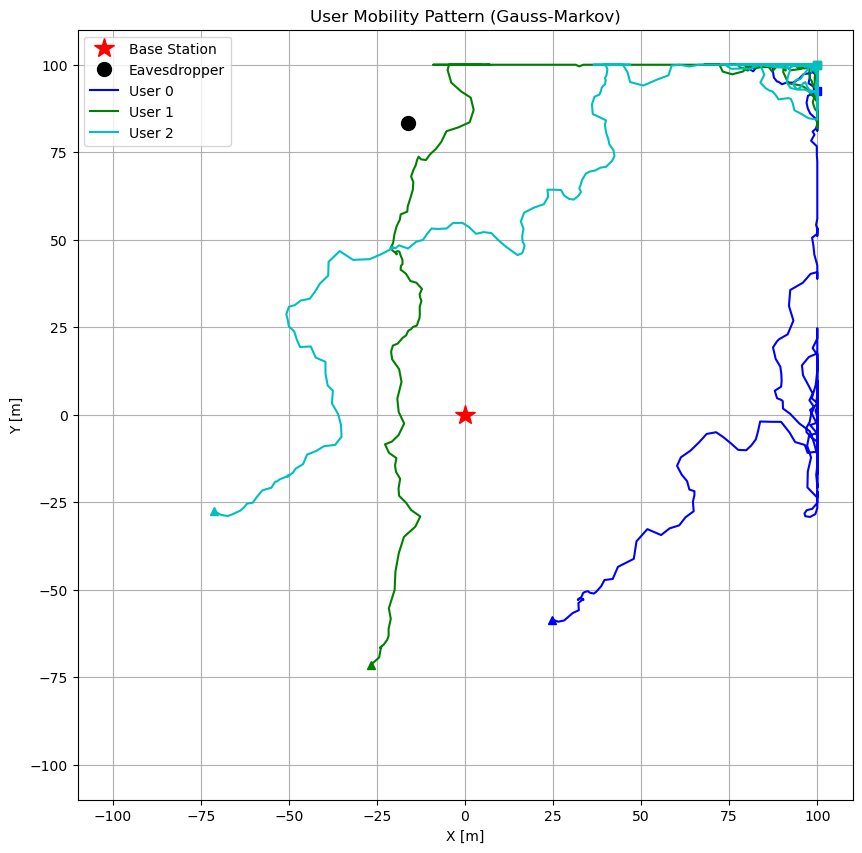

In [15]:
# Plotting
plt.figure(figsize=(10, 10))
plt.plot(bs_pos[0], bs_pos[1], 'r*', markersize=15, label='Base Station')
plt.plot(eve_pos[0], eve_pos[1], 'ko', markersize=10, label='Eavesdropper')

colors = ['b', 'g', 'c', 'm', 'y']
for i in range(config.M_users):
    plt.plot(user_positions[i]['x'], user_positions[i]['y'], color=colors[i%len(colors)], label=f'User {i}')
    plt.plot(user_positions[i]['x'][0], user_positions[i]['y'][0], color=colors[i%len(colors)], marker='^') # Start
    plt.plot(user_positions[i]['x'][-1], user_positions[i]['y'][-1], color=colors[i%len(colors)], marker='s') # End

plt.xlim([-110, 110])
plt.ylim([-110, 110])
plt.grid(True)
plt.legend()
plt.title("User Mobility Pattern (Gauss-Markov)")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.show()

***Log giá trị secrecy-rate mới của môi trường multi-step***

/var/folders/d3/gbvcsztx4p7990v3cy80kqmw0000gn/T/ipykernel_38548/2710096836.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()
/var/folders/d3/gbvcsztx4p7990v3cy80kqmw0000gn/T/ipykernel_38548/2710096836.py:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


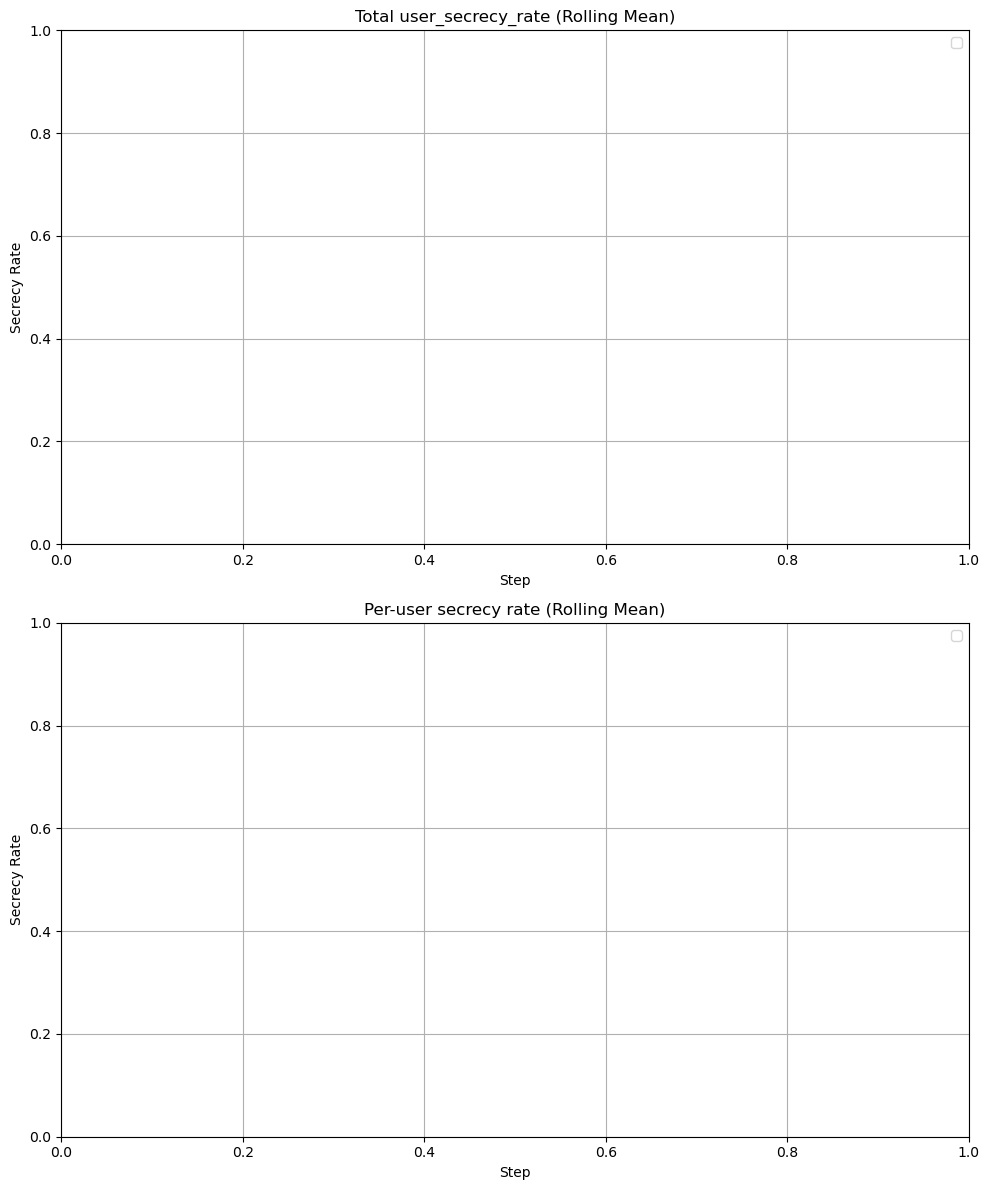

In [16]:
result_list = [
    # "/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765069988no_custom_name_PPO_timeStep_300000.monitor.csv",
    # "/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765070305no_custom_name_PPO_timeStep_3000000.monitor.csv",
    "/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765073637no_custom_name_PPO_timeStep_300000.monitor.csv",
    "/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765074017no_custom_name_PPO_timeStep_1000000.monitor.csv",
    "/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765074687no_custom_name_PPO_timeStep_1000000.monitor.csv",
    
]


result_list_1M = [
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765074017no_custom_name_PPO_timeStep_1000000.monitor.csv',
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765074687no_custom_name_PPO_timeStep_1000000.monitor.csv',
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765075458no_custom_name_PPO_timeStep_1000000.monitor.csv',
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765076094no_custom_name_PPO_timeStep_1000000.monitor.csv',
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765076739no_custom_name_PPO_timeStep_1000000.monitor.csv',
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765077378no_custom_name_PPO_timeStep_1000000.monitor.csv',
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765078017no_custom_name_PPO_timeStep_1000000.monitor.csv'

]

result_list_1M_Normalize = [
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765081798no_custom_name_PPO_timeStep_1000000.monitor.csv',
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765082514no_custom_name_PPO_timeStep_1000000.monitor.csv',
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765084887no_custom_name_PPO_timeStep_1000000.monitor.csv',
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765085614no_custom_name_PPO_timeStep_1000000.monitor.csv',
    '/Users/taduylam/Workspace/Lab/0/3. MovableAntenna/monitor_log/PPO_1765086336no_custom_name_PPO_timeStep_1000000.monitor.csv'
]

result_list_300K_1_env = [
    ""
]


# colors = ['r', 'g', 'b', 'y']

# names = [
#     # "PPO-multistep-100-eps-300k",
#     # "PPO-multistep-100-eps-3M",
#     "PPO-multistep-100-eps-300K-goc",
#     "PPO-multistep-100-eps-1M-goc",
#     "PPO-multistep-100-eps-1M-goc"
# ]
cnt = 0

# adversarial policy -> 

def convert_str_arr(series):
    return series.apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

for path in result_list_300K_1_env:
    if path == "":
        continue

    df = pd.read_csv(path, skiprows=1)
    converted = convert_str_arr(df['user_security_rate'])

    # Convert Series → 2D numpy array
    matrix = np.vstack(converted.values)  # shape: (num_steps, num_users)

    total_secrecy = matrix.sum(axis=1)[:100]
    print(total_secrecy.shape)
    rolling = pd.Series(total_secrecy).rolling(window=1).mean()

    # ax[0].plot(rolling, color=colors[0], label=names[0])
    ax[0].plot(rolling, label=f"{cnt}")
    
    # colors.pop(0)
    # names.pop(0)

    num_users = matrix.shape[1]

    for u in range(num_users):
        ax[1].plot(
            pd.Series(matrix[:, u]).rolling(window=1).mean(),
            label=f"User {u} - {cnt}"
        )
    cnt += 1

ax[0].set_title("Total user_secrecy_rate (Rolling Mean)")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Secrecy Rate")
ax[0].grid()
ax[0].legend()

ax[1].set_title("Per-user secrecy rate (Rolling Mean)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Secrecy Rate")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()